In [4]:
import findspark

In [6]:
findspark.init('C:\SPARK')

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
        .master('local') \
        .appName('pyspark_uygulama') \
        .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local appName=pyspark_uygulama>

In [10]:
churn = spark.read.csv('C:/Users/umutk/Documents/python_calismalar/churn.csv', header=True, inferSchema=True, sep=',')
churn.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [11]:
churn.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [12]:
churn.show(3)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [17]:
# Tum sutun adlarini kucuk harfe cevirelim.

churn = churn.toDF(*[col.lower() for col in churn.columns])
churn = churn.withColumnRenamed('_c0', 'index')
churn.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [18]:
churn.count()

900

In [21]:
# Tum musteriler unique mi ?
print('Verisetindeki unique satirlar' ,churn.distinct().count())
print('Verisetindeki unique isimler', churn.select('names').distinct().count())

Verisetindeki unique satirlar 900
Verisetindeki unique isimler 899


In [32]:
# Duplicate olan ismi bulalim
churn.createOrReplaceTempView('table_churn')
spark.sql('select names from table_churn group by names having count(names) >1').show()

+-------------+
|        names|
+-------------+
|Jennifer Wood|
+-------------+



In [36]:
# Bu degerler duplicate mi yoksa ayni ada sahip 2 farkli musteri mi ?
spark.sql("select * from table_churn where names LIKE 'Jennifer Wood' ").show() # iki farkli musteri

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [37]:
# spark dataframe'de index'e erismek
churn.where(churn.index == 439).select('names').show()

+-------------+
|        names|
+-------------+
|Jennifer Wood|
+-------------+



In [44]:
# Peki bu indeksteki isme deger olarak erismek istersek ?
print(churn.where(churn.index == 439).collect())
churn.where(churn.index == 439).collect()[0]['names']

[Row(index=439, names='Jennifer Wood', age=48.0, total_purchase=11585.16, account_manager=0, years=4.61, num_sites=9.0, churn=0)]


'Jennifer Wood'

## EDA

In [50]:
churn.describe(['names','age','total_purchase','account_manager','years','num_sites','churn']).show()

+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|        names|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|          900|              900|              900|               900|              900|               900|                900|
|   mean|         NULL|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|         NULL|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|   Aaron King|             22.0|            100.0|                 0|              1.0|               3.0|                  0|
|    max|Zachary Walsh|             65.0|       

In [53]:
churn.describe(['names','age','total_purchase','account_manager','years','num_sites','churn']).toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
names,900,None,None,Aaron King,Zachary Walsh
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


**age** dagilimini bir gozden gecirelim

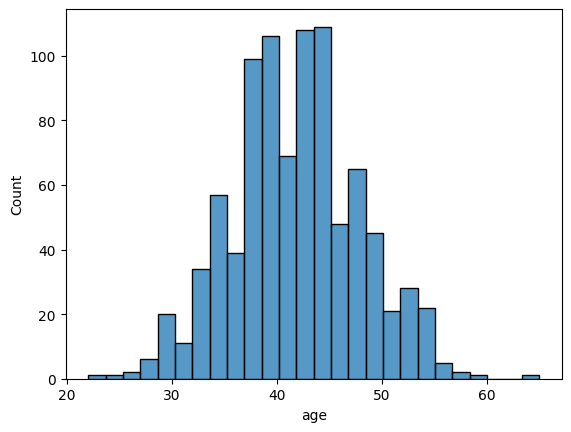

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

pd_churn = churn.toPandas()

sns.histplot(data=pd_churn, x='age')
plt.show()

In [65]:
print("Yasi 47'den buyuk olan musterilerimizin sayisi : ",churn.filter(churn.age > 47).count())

Yasi 47'den buyuk olan musterilerimizin sayisi :  161


In [66]:
churn.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [72]:
# Churn 0-1 iken de satin almalar birbirine yakin.

churn.groupby('churn').agg({'total_purchase' : 'mean'}).show()

+-----+-------------------+
|churn|avg(total_purchase)|
+-----+-------------------+
|    1| 10192.179933333337|
|    0| 10036.952853333332|
+-----+-------------------+



In [71]:
churn.groupby('churn').agg({'years' : 'median'}).show()

+-----+-------------+
|churn|median(years)|
+-----+-------------+
|    1|          5.8|
|    0|         5.08|
+-----+-------------+



In [81]:
# Korelasyonu incelenecek kisim
corr_data = churn.drop('index', 'names').toPandas()

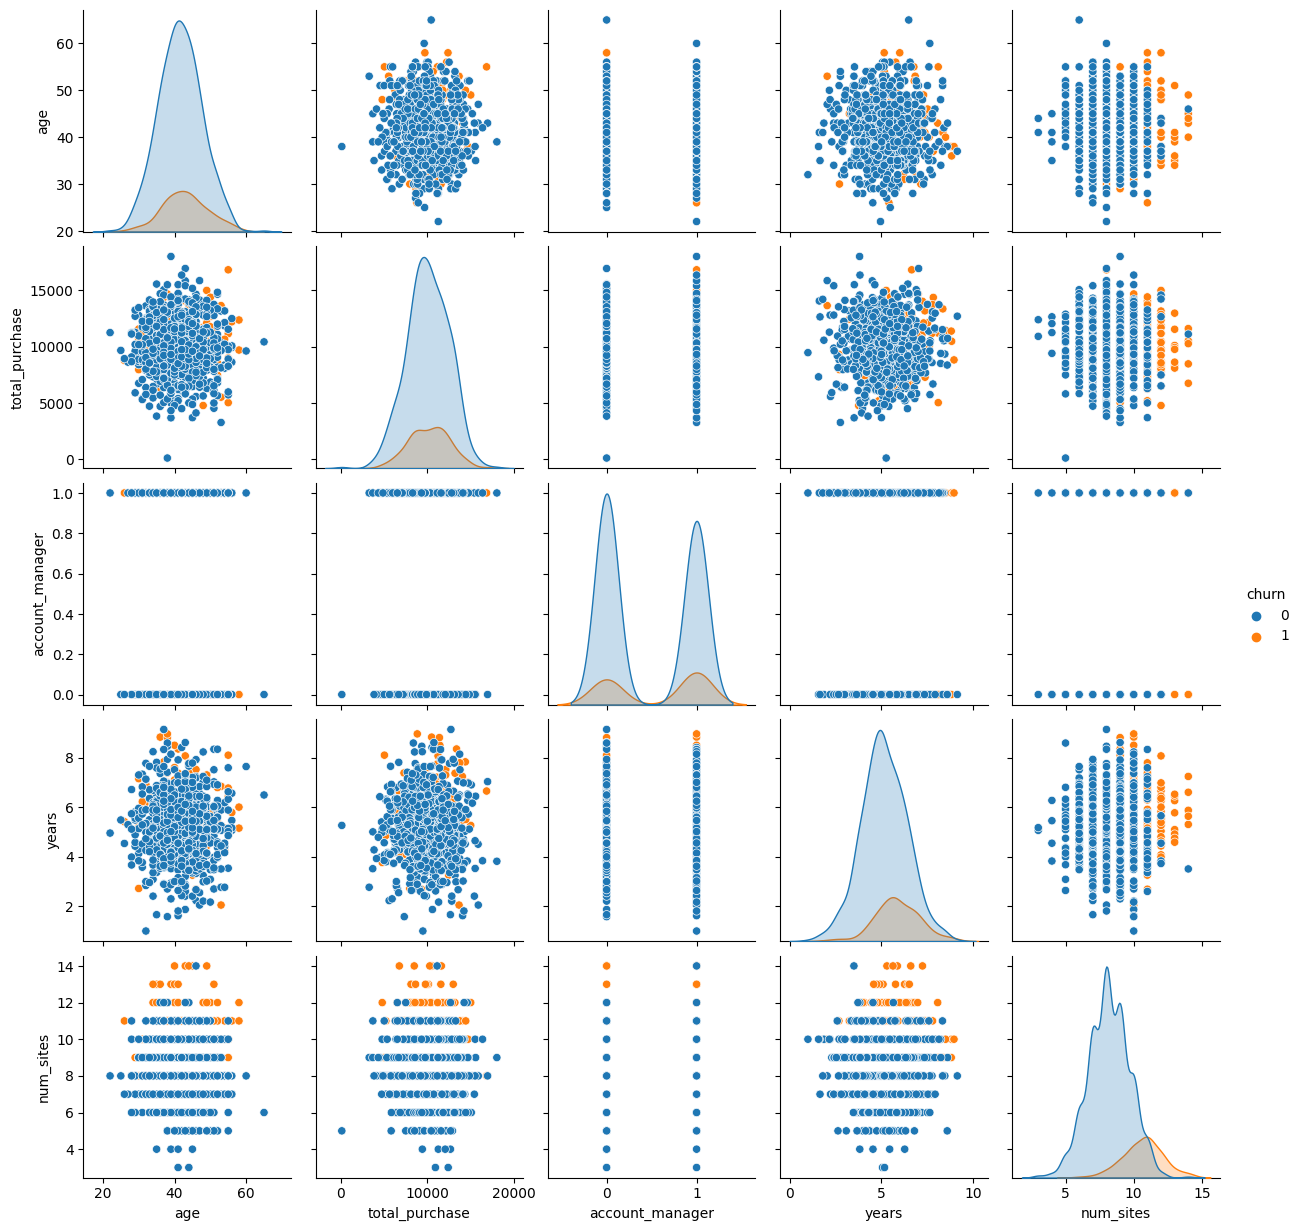

In [83]:
sns.pairplot(corr_data, hue='churn')
plt.show()

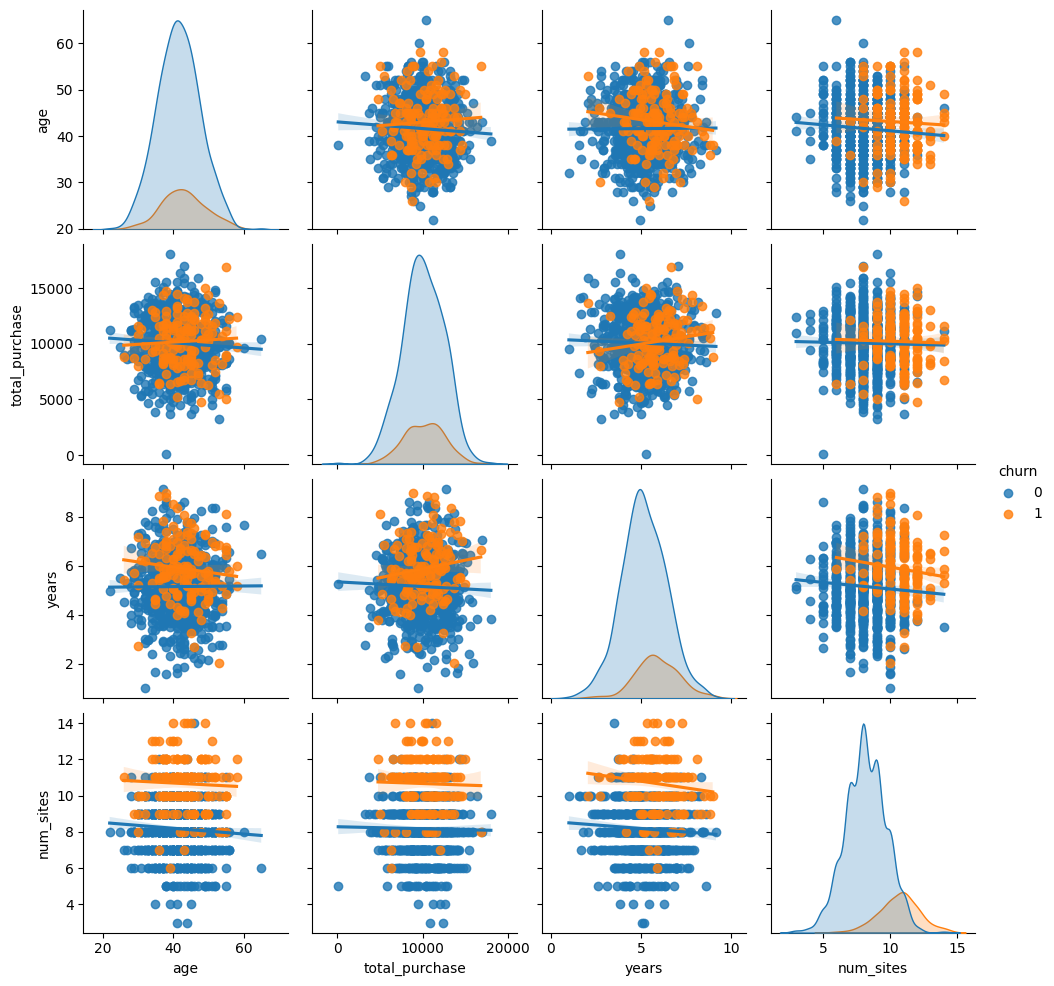

In [84]:
sns.pairplot(corr_data, vars = ['age', 'total_purchase', 'years', 'num_sites'], hue='churn', kind='reg')
plt.show()

## Data Preprocessing

In [85]:
churn = churn.dropna()

In [86]:
churn = churn.withColumn('age_kare', churn.age**2)

In [87]:
churn.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|age_kare|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1764.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1681.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1444.0|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
only showing top 3 rows



ML modelini kullanabilmek icin verimizi hazir hale getiriyoruz.

Burada **stringIndexer**'dan faydalanacagiz. Bu fonksiyon oldukca faydali

### Bagimli degisken ayarlama

In [88]:
from pyspark.ml.feature import StringIndexer

?StringIndexer

Init signature:
StringIndexer(
    *,
    inputCol: Optional[str] = None,
    outputCol: Optional[str] = None,
    inputCols: Optional[List[str]] = None,
    outputCols: Optional[List[str]] = None,
    handleInvalid: str = 'error',
    stringOrderType: str = 'frequencyDesc',
)
Docstring:     
A label indexer that maps a string column of labels to an ML column of label indices.
If the input column is numeric, we cast it to string and index the string values.
The indices are in [0, numLabels). By default, this is ordered by label frequencies
so the most frequent label gets index 0. The ordering behavior is controlled by
setting :py:attr:`stringOrderType`. Its default value is 'frequencyDesc'.

.. versionadded:: 1.4.0

Examples
--------
>>> stringIndexer = StringIndexer(inputCol="label", outputCol="indexed",
...     stringOrderType="frequencyDesc")
>>> stringIndexer.setHandleInvalid("error")
StringIndexer...
>>> model = stringIndexer.fit(stringIndDf)
>>> model.setHandleInvalid("error")
St

In [89]:
# Burada 'outputCol' label adi verilmesi genellesmis bir seydir artik.
# Bagimsiz degiskenlere de 'feature' adini verecegiz.
stringIndexer = StringIndexer(inputCol='churn', outputCol='label')

In [92]:
indexed = stringIndexer.fit(churn).transform(churn)

In [94]:
indexed.dtypes # label double formatinda bunu donusturelim.

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_kare', 'double'),
 ('label', 'double')]

In [96]:
churn = indexed.withColumn('label', indexed['label'].cast('integer'))

In [97]:
churn.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_kare', 'double'),
 ('label', 'int')]

### Bagimsiz degisken ayarlama

In [98]:
from pyspark.ml.feature import VectorAssembler

In [101]:
churn.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn',
 'age_kare',
 'label']

In [103]:
bagimsiz_degisken = ['age','total_purchase','account_manager','years','num_sites']

In [106]:
vectorAssembler = VectorAssembler(inputCols=bagimsiz_degisken, outputCol='features')

In [108]:
VA_df = vectorAssembler.transform(churn)

In [109]:
final_df = VA_df.select(['features', 'label'])

In [112]:
# pyspark'in istedigi formata getirmis olduk.
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



## Test-Train

In [113]:
splits = final_df.randomSplit([0.7,0.3])
train_df = splits[0]
test_df = splits[1]

In [114]:
train_df

DataFrame[features: vector, label: int]

In [115]:
test_df

DataFrame[features: vector, label: int]

## GBM ile modelleme

In [116]:
from pyspark.ml.classification import GBTClassifier

In [117]:
gbm = GBTClassifier(maxIter=10, featuresCol='features', labelCol='label')

In [118]:
gbm_model = gbm.fit(train_df)

### Ilkel bir sekilde test hatamizi da hesaplayalim.

In [121]:
y_pred = gbm_model.transform(test_df)
y_pred

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [122]:
ac = y_pred.select('label', 'prediction')

In [124]:
# Bu hesaplama bize modelin accuracy'sini verir.
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8754716981132076

### Model tuning

In [125]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2,4,6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

In [126]:
cv_model = cv.fit(train_df)

In [127]:
y_pred = cv_model.transform(test_df)

ac = y_pred.select('label', 'prediction')

In [128]:
#Accuracy score
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8981132075471698

In [129]:
# AUC degeri
evaluator.evaluate(y_pred)

0.9263152841781875

# Bu musteriler bizi terk eder mi ?

In [131]:
import pandas as pd
names = pd.Series(['Ali Ahmetoglu', 'Berkcan Tanerbey', 'Harika Gunduz', 'Polat Alemdar', 'Mesut Civelek'])
age = pd.Series([38, 43, 34, 50, 40])
total_purchase = pd.Series([30000, 10000, 6000, 30000, 100000])
account_manager = pd.Series([1, 0, 0, 1, 1])
years = pd.Series([20, 10, 3, 8, 30])
num_sites = pd.Series([30, 8, 8, 6, 50])

yeni_musteriler = pd.DataFrame({
    'names' : names,
    'age' : age,
    'total_purchase' : total_purchase,
    'account_manager' : account_manager,
    'years' : years,
    'num_sites' : num_sites
})

yeni_musteriler.columns

Index(['names', 'age', 'total_purchase', 'account_manager', 'years',
       'num_sites'],
      dtype='object')

In [132]:
yeni_musteriler

,names,age,total_purchase,account_manager,years,num_sites
0,Ali Ahmetoglu,38,30000,1,20,30
1,Berkcan Tanerbey,43,10000,0,10,8
2,Harika Gunduz,34,6000,0,3,8
3,Polat Alemdar,50,30000,1,8,6
4,Mesut Civelek,40,100000,1,30,50


In [136]:
# Modele sokabilmek icin sparkdf formuna aldik.
yeni_sdf = spark.createDataFrame(yeni_musteriler)

In [137]:
type(yeni_sdf)

pyspark.sql.dataframe.DataFrame

In [138]:
yeni_sdf.show()

+----------------+---+--------------+---------------+-----+---------+
|           names|age|total_purchase|account_manager|years|num_sites|
+----------------+---+--------------+---------------+-----+---------+
|   Ali Ahmetoglu| 38|         30000|              1|   20|       30|
|Berkcan Tanerbey| 43|         10000|              0|   10|        8|
|   Harika Gunduz| 34|          6000|              0|    3|        8|
|   Polat Alemdar| 50|         30000|              1|    8|        6|
|   Mesut Civelek| 40|        100000|              1|   30|       50|
+----------------+---+--------------+---------------+-----+---------+



In [139]:
yeni_musteriler = vectorAssembler.transform(yeni_sdf)

In [141]:
sonuclar = cv_model.transform(yeni_musteriler)

In [146]:
sonuclar.select('names', 'prediction', 'probability').show()

+----------------+----------+--------------------+
|           names|prediction|         probability|
+----------------+----------+--------------------+
|   Ali Ahmetoglu|       1.0|[0.20540707127087...|
|Berkcan Tanerbey|       0.0|[0.91862471439402...|
|   Harika Gunduz|       0.0|[0.91486380285819...|
|   Polat Alemdar|       0.0|[0.92758350555971...|
|   Mesut Civelek|       1.0|[0.20540707127087...|
+----------------+----------+--------------------+



In [147]:
sc.stop()